<a href="https://colab.research.google.com/github/lr13953301387/8715_project/blob/yang_Branch/siamese(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Siamese Neural Network for hand-writing analysis


Training a Siamese neural network for handwriting analysis to identify whether two Japanese characters are written by the same person involves several steps. Below is a general guideline:

Overview of Siamese Neural Network
A Siamese neural network consists of two identical subnetworks, which are used to extract features from two input images. The outputs of these subnetworks are then compared to compute a similarity score, which is used to determine whether the two input images are similar or dissimilar.

###### 1. Data Preparation
Data Loading: Extract and load the images.
Pair Creation: Create positive pairs (characters written by the same person) and negative pairs (characters written by different persons).
Data Preprocessing: Normalize images, handle imbalanced data, etc.

###### 2. Model Architecture
Feature Extractor: Define the subnetwork architecture for feature extraction (CNNs are commonly used).
Distance Measure: Choose a method for computing the similarity between the feature vectors (e.g., Euclidean distance).
Loss Function: Choose a loss function that encourages the network to learn a useful similarity measure (e.g., contrastive loss).

###### 3. Training
Batch Sampling: Choose how to sample pairs of images during training.
Training Loop: Update the network's weights based on the loss, typically using gradient descent.

###### 4. Evaluation
Model Evaluation: Evaluate the model on a validation/test set and optimize it for specific metrics (e.g., accuracy, F1-score).
Fine-tuning: Adjust hyperparameters and retrain if necessary.

###### 5. Deployment
Deploy the model for practical use.

In [41]:
import itertools
import random
from collections import defaultdict
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [42]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### 1. Data Preparation
#### 1.1 Setting up the dataset
See code in reorganize_data.py

The expected format for both the training and validation dataset is the same. Image belonging to a single entity/class should be placed in a folder with the name of the class. The folders for every class are then to be placed within a common root directory (which will be passed to the trainined and evaluation scripts), i.e.

|--Train or Validation dataset root directory <br>
&ensp;|--Writer 1 <br>
&emsp;&emsp;|-Image1<br>
&emsp;&emsp;|-Image2<br>
&emsp;&emsp;.<br>
&emsp;&emsp;.<br>
&emsp;&emsp;.<br>
&emsp;&emsp;|-ImageN<br>
&ensp; |--Writer 2<br>
&ensp; |--Writer 3<br>
&ensp; .<br>
&ensp; .<br>
&ensp; .<br>
&ensp; |--Writer N<br>

In [43]:
data_path = '/content/drive/MyDrive/6390HCI/data'

# List all writers' directories
writers = [w for w in os.listdir(data_path) if os.path.isdir(os.path.join(data_path, w)) and not w.startswith('.')]

print(writers)

['Denvour', 'MOH', 'yongsong', 'D', 'C', 'Grant', 'Monica', 'B']


In [44]:
writers_in_data = os.listdir(data_path)
writer_sample_files_in_data = {writer: os.listdir(os.path.join(data_path, writer))[:5] for writer in writers_in_data}

writers_in_data, writer_sample_files_in_data

(['Denvour', 'MOH', 'yongsong', 'D', 'C', 'Grant', 'Monica', 'B'],
 {'Denvour': ['13.jpg', '43.jpg', '11.jpg', '47.jpg', '18.jpg'],
  'MOH': ['58.jpg', '44.jpg', '36.jpg', '34.jpg', '43.jpg'],
  'yongsong': ['yongsong_1_33.jpg',
   'yongsong_2_4.jpg',
   'yongsong_1_39.jpg',
   'yongsong_5_34.jpg',
   'yongsong_4_0.jpg'],
  'D': ['D_1_17.jpg', 'D_2_37.jpg', 'D_3_30.jpg', 'D_2_46.jpg', 'D_2_6.jpg'],
  'C': ['C_3_8.jpg', 'C_3_27.jpg', 'C_3_19.jpg', 'C_4_7.jpg', 'C_4_5.jpg'],
  'Grant': ['15.jpg', '11.jpg', '28.jpg', '38.jpg', '24.jpg'],
  'Monica': ['73.jpg', '84.jpg', '28.jpg', '64.jpg', '106.jpg'],
  'B': ['B_3_2.jpg', 'B_4_26.jpg', 'B_4_72.jpg', 'B_2_18.jpg', 'B_1_32.jpg']})

#### 1.2 Visulizing a few iamges

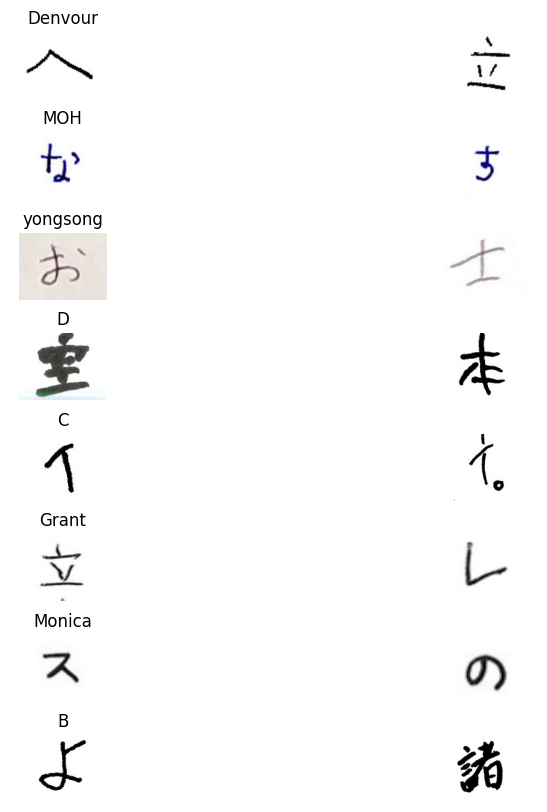

In [45]:
import matplotlib.pyplot as plt
import cv2

# Function to load and display a sample image from each writer
def display_sample_images(writers, writer_sample_files, data_path, num_samples=2):
    fig, axes = plt.subplots(len(writers), num_samples, figsize=(10, 10))
    fig.subplots_adjust(hspace=0.5, wspace=0.2)

    for i, writer in enumerate(writers):
        for j, file in enumerate(writer_sample_files[writer][:num_samples]):
            img_path = os.path.join(data_path, writer, file)
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB
            axes[i, j].imshow(img)
            axes[i, j].axis('off')
            if j == 0:
                axes[i, j].set_title(writer)

    plt.show()

# Displaying sample images
display_sample_images(writers_in_data, writer_sample_files_in_data, data_path)


#### 1.3 Contrast Enhancement and Normalization

In [46]:
# Function to enhance contrast using Adaptive Histogram Equalization (AHE)
def enhance_contrast_LAB(image, clip_limit=2.0, tile_grid_size=(8, 8)):
    # Convert to LAB color space
    lab = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
    l_channel, a, b = cv2.split(lab)

    # Applying CLAHE to L-channel
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)
    cl = clahe.apply(l_channel)

    # Merge the CLAHE enhanced L-channel with the a and b channel
    limg = cv2.merge((cl, a, b))

    # Convert back to RGB
    img_output = cv2.cvtColor(limg, cv2.COLOR_LAB2RGB)
    return img_output

# Function to enhance contrast using Adaptive Histogram Equalization (AHE)
def enhance_contrast_RGB(image, clip_limit=2.0, tile_grid_size=(8, 8)):
    # Convert to YUV color space
    img_yuv = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)

    # Apply AHE to the Y channel
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)
    img_yuv[:,:,0] = clahe.apply(img_yuv[:,:,0])

    # Convert back to RGB
    img_output = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2RGB)
    return img_output

# Function to apply histogram equalization
def equalize_histogram(image):
    # Convert to grayscale
    img_gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    # Apply histogram equalization
    img_hist_eq = cv2.equalizeHist(img_gray)

    # Convert back to RGB
    img_output = cv2.cvtColor(img_hist_eq, cv2.COLOR_GRAY2RGB)
    return img_output

# Create the sharpening kernel
def sharpening(image):
    kernel = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])

# Sharpen the image
    sharpened_image = cv2.filter2D(image, -1, kernel)

    return sharpened_image

# Function to normalize image
def normalize_image(image):
    return image / 255.0

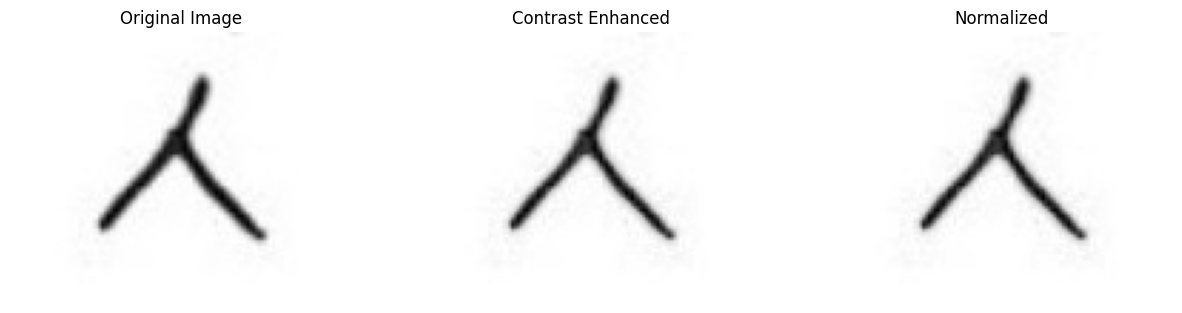

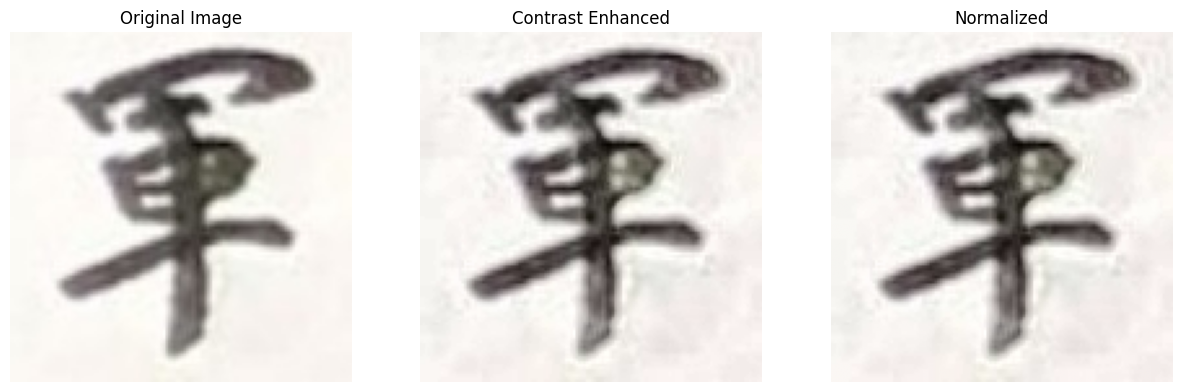

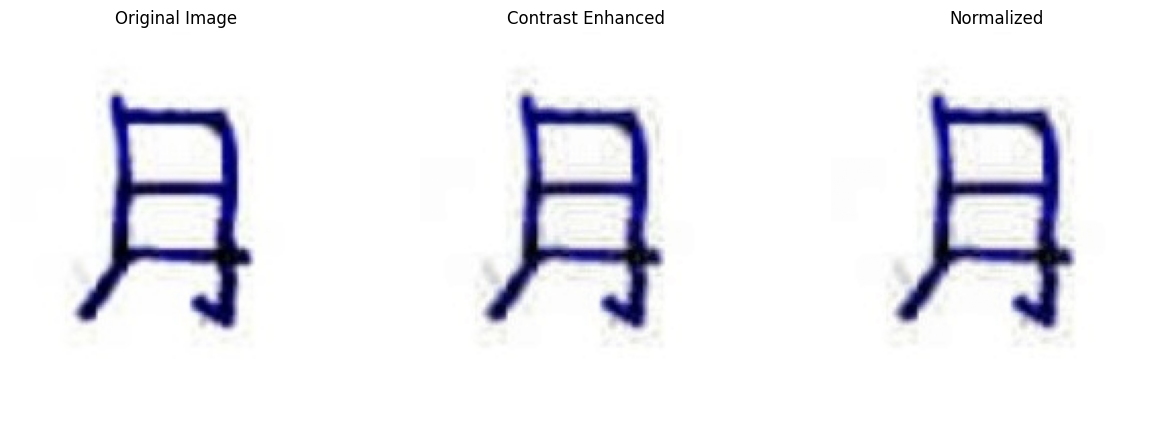

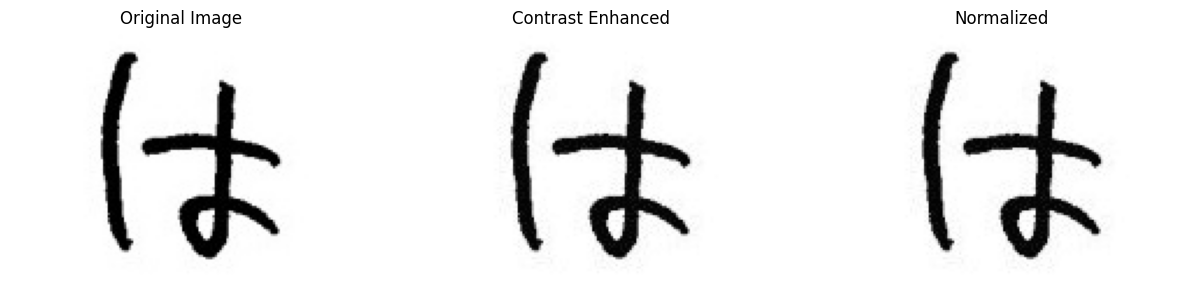

In [47]:
# Display original, contrast-enhanced, and normalized images
def display_preprocessed_images(image_path, clip_limit=2.0, tile_grid_size=(8, 8)):
    # Load image
    img = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Enhance contrast
    img_contrast_enhanced = enhance_contrast_RGB(img_rgb, clip_limit, tile_grid_size)

    # Normalize
    img_normalized = normalize_image(img_contrast_enhanced)

    # Display
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes[0].imshow(img_rgb)
    axes[0].set_title('Original Image')
    axes[1].imshow(img_contrast_enhanced)
    axes[1].set_title('Contrast Enhanced')
    axes[2].imshow(img_normalized)
    axes[2].set_title('Normalized')

    for ax in axes:
        ax.axis('off')

    plt.show()

# Sample paths for different writers
sample_image_paths = [
    os.path.join(data_path, 'Monica', '0.jpg'),
    os.path.join(data_path, 'yongsong', 'yongsong_5_26.jpg'),
    os.path.join(data_path, 'MOH', '60.jpg'),
    os.path.join(data_path, 'D', 'D_5_11.jpg'),
]

# Display preprocessed images for the sample paths
for img_path in sample_image_paths:
    display_preprocessed_images(img_path)


#### 1.4 Standardizing Images

In [48]:
def resize_and_pad(image, size, pad_value='edge'):
    # Keeping the aspect ratio and padding
    h, w, _ = image.shape
    if h > w:
        new_h, new_w = size, int(w * size / h)
    else:
        new_h, new_w = int(h * size / w), size

    resized_image = cv2.resize(image, (new_w, new_h), interpolation=cv2.INTER_AREA)

    # Padding
    if pad_value == 'edge':
        # Using edge values for padding
        pad_value = resized_image[0, 0].tolist()

    padded_image = np.full((size, size, 3), pad_value, dtype=np.uint8)
    y_offset = (size - new_h) // 2
    x_offset = (size - new_w) // 2

    padded_image[y_offset:y_offset+new_h, x_offset:x_offset+new_w] = resized_image

    return padded_image

['/content/drive/MyDrive/6390HCI/data/Monica/69.jpg']
(95, 134, 3)
(100, 100, 3)


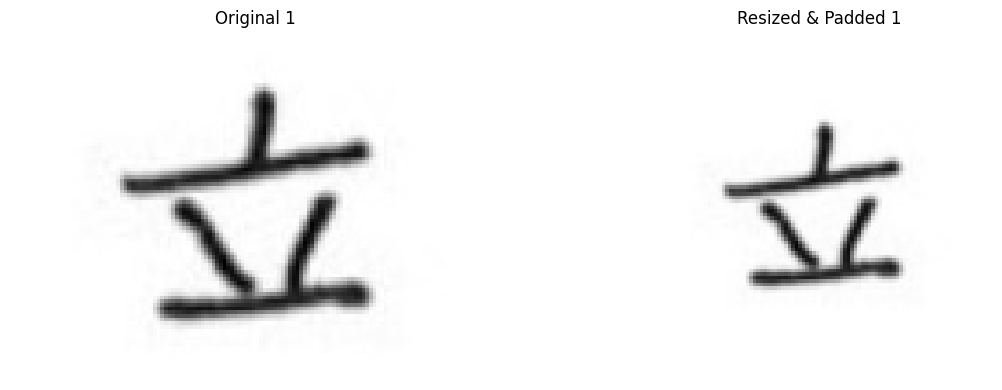

In [49]:
# Sample image paths
sample_paths = ['/content/drive/MyDrive/6390HCI/data/Monica/69.jpg']
print(sample_paths)

# Display original and resized+padded images
plt.figure(figsize=(12, 4))

for i, img_path in enumerate(sample_paths):
    # Load image
    img = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Apply resize_and_pad function
    resized_img = resize_and_pad(img_rgb, 100) # Example size = 100

    print(img.shape)
    print(resized_img.shape)

    # Display images
    plt.subplot(len(sample_paths), 2, 2*i + 1)
    plt.imshow(img_rgb)
    plt.title(f'Original {i+1}')
    plt.axis('off')

    plt.subplot(len(sample_paths), 2, 2*i + 2)
    plt.imshow(resized_img)
    plt.title(f'Resized & Padded {i+1}')
    plt.axis('off')

plt.tight_layout()
plt.show()

#### 1.5 Creating image pairs

In [50]:
import random
import numpy as np
import torch

# Set the seed for random processes
seed_value = 21
random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)

def create_pairs(data_path, writers, num_pairs_per_writer=100):
    positive_pairs = []
    negative_pairs = []
    positive_labels = []
    negative_labels = []

    # Loop over each writer
    for writer in writers:
        writer_folder_path = os.path.join(data_path, writer)
        writer_images = os.listdir(writer_folder_path)

        # Create positive pairs for the current writer
        for _ in range(num_pairs_per_writer):
            img1_name, img2_name = random.sample(writer_images, 2)
            img1_path = os.path.join(writer_folder_path, img1_name)
            img2_path = os.path.join(writer_folder_path, img2_name)
            positive_pairs.append((img1_path, img2_path))
            positive_labels.append(1)

        # Create negative pairs
        other_writers = [w for w in writers if w != writer]
        for _ in range(num_pairs_per_writer):
            img1_name = random.choice(writer_images)
            img1_path = os.path.join(writer_folder_path, img1_name)

            other_writer = random.choice(other_writers)
            other_writer_folder = os.path.join(data_path, other_writer)
            img2_name = random.choice(os.listdir(other_writer_folder))
            img2_path = os.path.join(other_writer_folder, img2_name)

            negative_pairs.append((img1_path, img2_path))
            negative_labels.append(0)

    # Combining positive and negative pairs and shuffling them
    all_pairs = positive_pairs + negative_pairs
    all_labels = positive_labels + negative_labels

    # Shuffle pairs and labels in unison
    combined = list(zip(all_pairs, all_labels))
    random.shuffle(combined)
    all_pairs[:], all_labels[:] = zip(*combined)

    return all_pairs, all_labels, combined

# For the sake of this example, let's use a subset of writers to create pairs
selected_writers = ['Monica', 'yongsong', 'MOH', 'Denvour', 'B', 'C', 'D', 'Grant']

# Create image pairs
all_pairs, all_labels, combined = create_pairs(data_path, selected_writers)

# Check the first few pairs and labels
all_pairs[:5], all_labels[:5]

print(combined)

[(('/content/drive/MyDrive/6390HCI/data/Denvour/20.jpg', '/content/drive/MyDrive/6390HCI/data/Denvour/61.jpg'), 1), (('/content/drive/MyDrive/6390HCI/data/C/C_5_46.jpg', '/content/drive/MyDrive/6390HCI/data/Monica/97.jpg'), 0), (('/content/drive/MyDrive/6390HCI/data/B/B_4_97.jpg', '/content/drive/MyDrive/6390HCI/data/MOH/0.jpg'), 0), (('/content/drive/MyDrive/6390HCI/data/yongsong/yongsong_1_7.jpg', '/content/drive/MyDrive/6390HCI/data/yongsong/yongsong_3_17.jpg'), 1), (('/content/drive/MyDrive/6390HCI/data/B/B_1_3.jpg', '/content/drive/MyDrive/6390HCI/data/C/C_4_43.jpg'), 0), (('/content/drive/MyDrive/6390HCI/data/Denvour/56.jpg', '/content/drive/MyDrive/6390HCI/data/Denvour/62.jpg'), 1), (('/content/drive/MyDrive/6390HCI/data/Monica/88.jpg', '/content/drive/MyDrive/6390HCI/data/C/C_3_11.jpg'), 0), (('/content/drive/MyDrive/6390HCI/data/Denvour/50.jpg', '/content/drive/MyDrive/6390HCI/data/Grant/27.jpg'), 0), (('/content/drive/MyDrive/6390HCI/data/C/C_5_47.jpg', '/content/drive/MyDriv

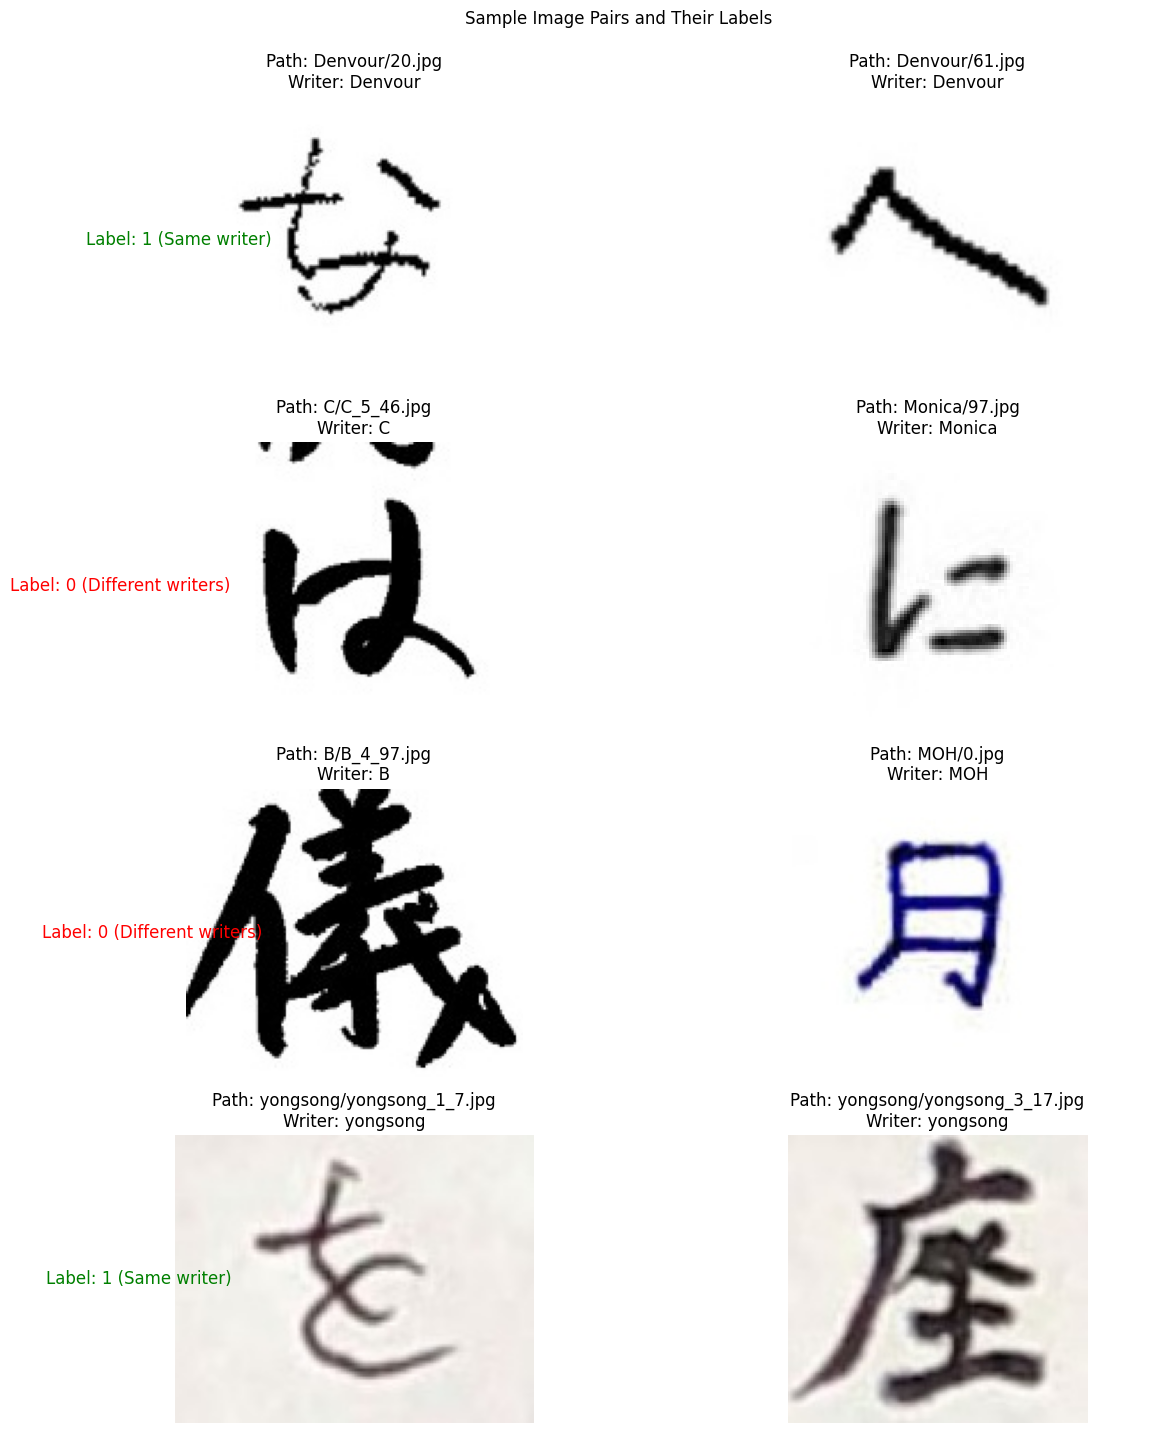

In [51]:
# Visualizing some of the pairs along with their labels in a unified manner with adjusted label positioning
fig, axs = plt.subplots(4, 2, figsize=(14, 14))

# Selecting a few pairs to visualize
selected_pairs = all_pairs[:4]
selected_labels = all_labels[:4]

for i, (pair, label) in enumerate(zip(selected_pairs, selected_labels)):
    for j, img_path in enumerate(pair):
        img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
        axs[i, j].imshow(img)
        axs[i, j].axis('off')
        axs[i, j].set_title(f"Path: {'/'.join(img_path.split('/')[-2:])}\nWriter: {img_path.split('/')[-2]}")

    # Using ax.text to place the label related to the subplot instead of the whole figure
    axs[i, 0].text(-0.1, 0.5, f"Label: {label} (Same writer)" if label == 1 else f"Label: {label} (Different writers)",
                   ha="center", va="center", fontsize=12, color="g" if label == 1 else "r", transform=axs[i, 0].transAxes)

plt.tight_layout()
plt.suptitle('Sample Image Pairs and Their Labels', y=1.02)
plt.show()



In [52]:
from sklearn.model_selection import train_test_split

# Split the pairs and labels into training and validation sets (80% training, 20% validation)
train_pairs, val_pairs, train_labels, val_labels = train_test_split(
    all_pairs, all_labels, test_size=0.2, random_state=42
)

# Check the number of training and validation pairs
len(train_pairs), len(val_pairs)


(1280, 320)

Define siamese neural network

In [53]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Define the backbone model: A simple CNN
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(128 * 16 * 16, 256)  # Assuming image size is 64x64

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 128 * 16 * 16)
        x = F.relu(self.fc1(x))
        return x

# Define the Siamese Network
class SiameseNetwork(nn.Module):
    def __init__(self, backbone):
        super(SiameseNetwork, self).__init__()
        self.backbone = backbone
        self.fc = nn.Linear(256, 1)  # Assuming the backbone outputs a 256-dim feature vector

    def forward(self, img1, img2):
        # Extract features using the backbone
        feat1 = self.backbone(img1)
        feat2 = self.backbone(img2)

        # Compute the absolute difference between the two feature vectors
        diff = torch.abs(feat1 - feat2)

        # Compute the similarity score
        score = torch.sigmoid(self.fc(diff))
        return score

# Initialize the models
backbone = SimpleCNN()
siamese_net = SiameseNetwork(backbone)


In [54]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

class SiameseDataset(Dataset):
    def __init__(self, image_pairs, labels, transform=None):
        self.image_pairs = image_pairs  # List of tuples (img_path1, img_path2)
        self.labels = labels  # List of labels (0 or 1)
        self.transform = transform  # Image transformations

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        img_path1, img_path2 = self.image_pairs[idx]
        label = self.labels[idx]

        # Load images
        img1 = Image.open(img_path1)
        img2 = Image.open(img_path2)

        # Apply transformations
        if self.transform:
            img1 = self.transform(img1)
            img2 = self.transform(img2)

        return (img1, img2), torch.tensor(label, dtype=torch.float32)

# Define image transformations (to tensor and normalization)
transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Resize images to a suitable size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create datasets
train_dataset = SiameseDataset(train_pairs, train_labels, transform=transform)
val_dataset = SiameseDataset(val_pairs, val_labels, transform=transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


In [55]:
import torch.optim as optim

# Contrastive Loss
class ContrastiveLoss(nn.Module):
    def __init__(self, margin):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output, label):
        euclidean_distance = F.pairwise_distance(output[0], output[1])
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))
        return loss_contrastive

def train_siamese_network(siamese_net, train_loader, num_epochs=25, margin=2.0):
    criterion = ContrastiveLoss(margin)
    optimizer = optim.Adam(siamese_net.parameters(), lr=0.0005)

    for epoch in range(num_epochs):
        running_loss = 0.0
        for i, ((img1, img2), labels) in enumerate(train_loader):
            optimizer.zero_grad()
            # Pass both images through the network
            output = siamese_net(img1, img2)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader)}")
    print("Finished Training")


# Example usage (ensure to run on local machine with GPU/CPU compatible with PyTorch)
# train_siamese_network(siamese_net, train_loader)


In [56]:
train_siamese_network(siamese_net, train_loader, num_epochs=25, margin=2.0)

Epoch 1/25, Loss: 1.5862161740660667
Epoch 2/25, Loss: 1.4805160909891129
Epoch 3/25, Loss: 1.4959525376558305
Epoch 4/25, Loss: 1.391975423693657
Epoch 5/25, Loss: 1.483676452934742
Epoch 6/25, Loss: 1.5892630204558373
Epoch 7/25, Loss: 1.4012400776147842
Epoch 8/25, Loss: 1.4583934873342514
Epoch 9/25, Loss: 1.3758197098970413
Epoch 10/25, Loss: 1.5360065519809722
Epoch 11/25, Loss: 1.5386388137936593
Epoch 12/25, Loss: 1.571221448481083
Epoch 13/25, Loss: 1.4976750254631042
Epoch 14/25, Loss: 1.4092150077223777
Epoch 15/25, Loss: 1.357759130001068
Epoch 16/25, Loss: 1.4560866743326186
Epoch 17/25, Loss: 1.5060073748230933
Epoch 18/25, Loss: 1.53321982473135
Epoch 19/25, Loss: 1.564456307888031
Epoch 20/25, Loss: 1.416987881064415
Epoch 21/25, Loss: 1.6682805240154266
Epoch 22/25, Loss: 1.381155650317669
Epoch 23/25, Loss: 1.4628418117761612
Epoch 24/25, Loss: 1.4380747392773627
Epoch 25/25, Loss: 1.4027536690235138
Finished Training


In [57]:
def predict_similarity(image1, image2, model, transform=None):
    """
    Predict the similarity between two images using a trained Siamese Network.

    Parameters:
    - image1, image2: PIL.Image.Image objects - the pair of images to compare.
    - model: torch.nn.Module - the trained Siamese Network.
    - transform: torchvision.transforms.Compose - transformations to apply to the images before passing them through the network.

    Returns:
    float - the predicted similarity score between the two images.
    """
    # Apply transformations if defined
    if transform:
        image1 = transform(image1)
        image2 = transform(image2)

    # Add batch dimension and move to appropriate device
    image1 = image1.unsqueeze(0).to(next(model.parameters()).device)
    image2 = image2.unsqueeze(0).to(next(model.parameters()).device)

    # Pass images through the model
    with torch.no_grad():
        model.eval()  # Set model to evaluation mode
        similarity_score = model(image1, image2).item()

    return round(similarity_score, 4)

In [58]:
i1 = Image.open('/content/drive/MyDrive/6390HCI/data/Denvour/41.jpg')
i2 = Image.open('/content/drive/MyDrive/6390HCI/data/C/C_1_2.jpg')
predict_similarity(i1, i2, siamese_net, transform)

0.0003

In [59]:
# Function to create positive and negative pairs
def create_pairs(data_path, writers):
    all_pairs = []
    all_labels = []

    # List all writers' directories
    writers = [w for w in os.listdir(data_path) if os.path.isdir(os.path.join(data_path, w)) and not w.startswith('.')]

    # Creating pairs
    for writer in writers:
        writer_path = os.path.join(data_path, writer)
        writer_imgs = [img for img in os.listdir(writer_path) if not img.startswith('.') and not os.path.isdir(os.path.join(writer_path, img))]

        # Positive pairs (same writer)
        pos_pairs = list(itertools.combinations(writer_imgs, 2))  # All possible pairs of images from the same writer
        pos_pairs = [(os.path.join(writer, img1), os.path.join(writer, img2)) for img1, img2 in pos_pairs]
        pos_labels = [1] * len(pos_pairs)

        # Negative pairs (different writers)
        other_writers = [w for w in writers if w != writer]
        neg_pairs = []
        for other_writer in other_writers:
            other_writer_path = os.path.join(data_path, other_writer)
            other_writer_imgs = [img for img in os.listdir(other_writer_path) if not img.startswith('.') and not os.path.isdir(os.path.join(other_writer_path, img))]
            for img1 in writer_imgs:
                for img2 in other_writer_imgs:
                    neg_pairs.append((os.path.join(writer, img1), os.path.join(other_writer, img2)))
        neg_labels = [0] * len(neg_pairs)

        # Concatenating positive and negative pairs
        all_pairs.extend(pos_pairs + neg_pairs)
        all_labels.extend(pos_labels + neg_labels)

    return all_pairs, all_labels

In [60]:

# Creating the pairs
pairs, labels = create_pairs(data_path, writers)

df = pd.DataFrame({'pair': pairs, 'label': labels})

# Shuffling and splitting the data into train, val, and test
train_ratio, val_ratio, test_ratio = 0.7, 0.2, 0.1
train_df = df.sample(frac=train_ratio, random_state=42)
remaining_df = df.drop(train_df.index)
val_df = remaining_df.sample(frac=val_ratio/(val_ratio + test_ratio), random_state=42)
test_df = remaining_df.drop(val_df.index)

# Displaying the number of pairs in each set
len(train_df), len(val_df), len(test_df)

(1495617, 427319, 213660)

In [61]:
print(len(pairs))

2136596


Visualizing pairs

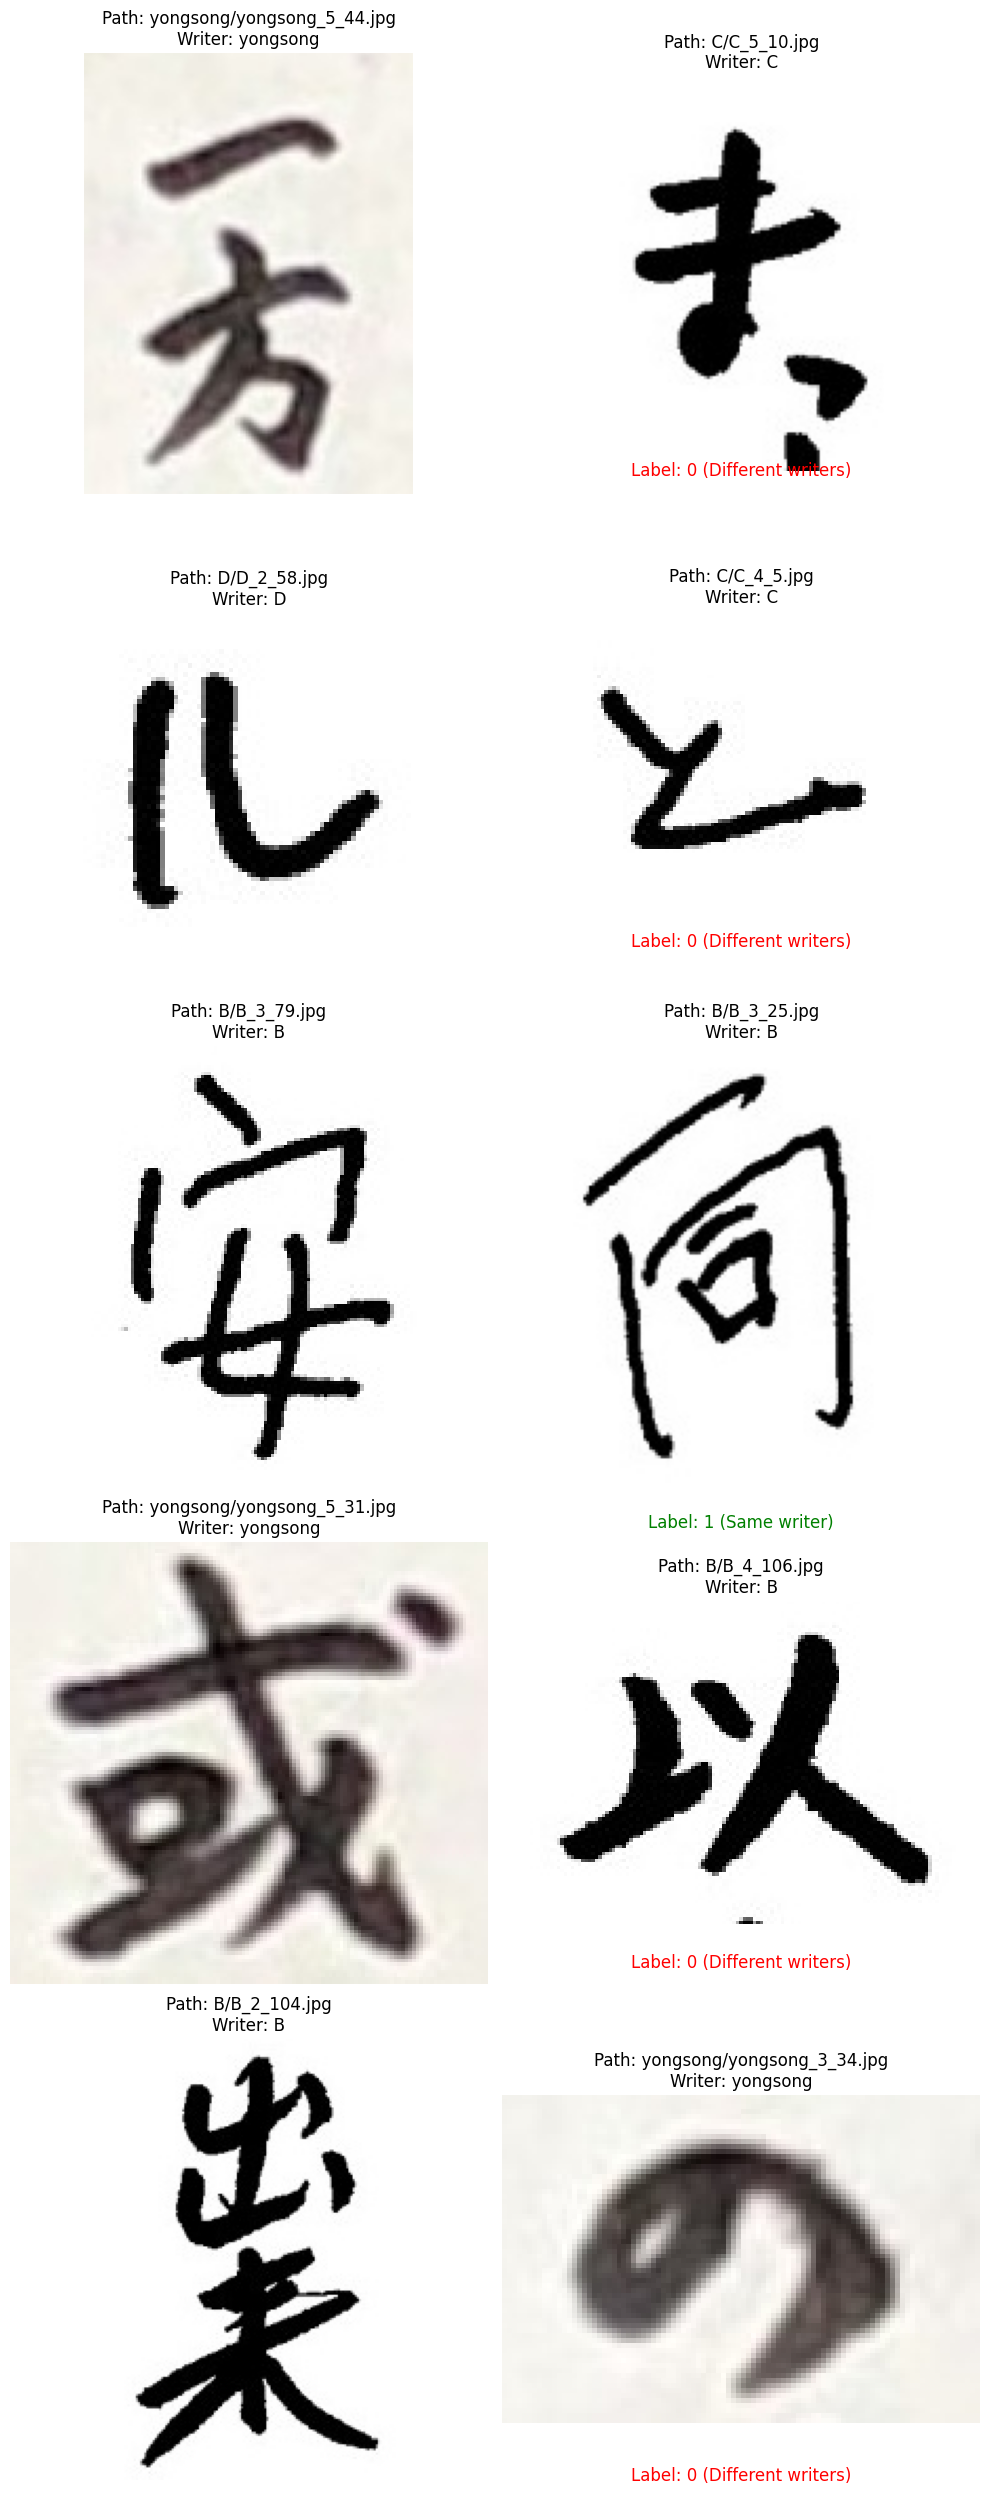

In [62]:
# Function to display image pairs with image paths
def display_image_pairs_with_paths(pairs_df, num_pairs=5):
    fig, axes = plt.subplots(num_pairs, 2, figsize=(10, num_pairs * 5))
    selected_pairs = pairs_df.sample(n=num_pairs).reset_index(drop=True)

    for i, (pair, label) in enumerate(zip(selected_pairs['pair'], selected_pairs['label'])):
        for j, img_path in enumerate(pair):
            img = plt.imread(os.path.join(data_path, img_path))
            axes[i, j].imshow(img, cmap='gray')
            axes[i, j].axis('off')
            axes[i, j].set_title(f"Path: {img_path}\nWriter: {img_path.split('/')[0]}")
        plt.figtext(0.5, -(i/num_pairs/5), f"Label: {label} (Same writer)" if label == 1 else f"Label: {label} (Different writers)",
                    ha="center", va="center", fontsize=12, color="g" if label == 1 else "r", transform=axes[i, j].transAxes)
    plt.tight_layout()
    plt.show()

# Displaying some random pairs from the training set
display_image_pairs_with_paths(test_df, num_pairs=5)


In [64]:
def evaluate_model(model, dataloader, threshold=0.5):
    model.eval()
    correct_preds = 0
    total_preds = 0

    for (img1, img2), labels in dataloader:
        # Ensure the images and labels are on the same device as the model
        img1 = img1.to(next(model.parameters()).device)
        img2 = img2.to(next(model.parameters()).device)
        labels = labels.to(next(model.parameters()).device)

        # Make predictions
        with torch.no_grad():
            outputs = model(img1, img2)

        # Compare predictions to threshold
        preds = (outputs > threshold).float()
        correct_preds += (preds.squeeze() == labels).sum().item()
        total_preds += labels.size(0)

    accuracy = correct_preds / total_preds
    return accuracy

# Example usage
accuracy = evaluate_model(siamese_net, val_loader)
print(f"Validation Accuracy: {accuracy * 100:.2f}%")


Validation Accuracy: 45.62%
